In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../Data/bank-additional-full.csv", sep = ";")
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
data.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

# Preparación del dataset

## Preparación en train y test

**Seleccion de variable target**

In [4]:
y = data.y
X = data.drop(["y"], axis = 1)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [7]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy= 0.3 ,random_state=123); # iguala las clases

X_train_us,y_train_us = undersampler.fit_resample(X_train,y_train)

In [8]:
X_train_numerical = X_train_us.select_dtypes(exclude = "object")
X_test_numerical = X_test.select_dtypes(exclude = "object")

In [9]:
X_train_categorical = X_train_us.select_dtypes(include='object')
X_test_categorical = X_test.select_dtypes(include='object')

In [10]:
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown = "ignore", sparse = False)
X_train_categorical_OH =  pd.DataFrame (OH_encoder.fit_transform(X_train_categorical))
X_train_categorical_OH.index = X_train_categorical.index

X_test_categorical_OH = pd.DataFrame (OH_encoder.transform(X_test_categorical))
X_test_categorical_OH.index = X_test_categorical.index

In [11]:
X_train = pd.concat([X_train_numerical, X_train_categorical_OH], axis = 1)
X_test = pd.concat([X_test_numerical, X_test_categorical_OH], axis = 1)

## **Logistic regression**

In [12]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_numerical_std = pd.DataFrame(sc_X.fit_transform(X_train_numerical))
X_train_numerical_std.index = X_train_numerical.index

X_test_numerical_std = pd.DataFrame(sc_X.transform(X_test_numerical))
X_test_numerical_std.index = X_test_numerical.index

In [13]:
X_train_log = pd.concat([X_train_numerical_std, X_train_categorical_OH], axis = 1)
X_test_log = pd.concat([X_test_numerical_std, X_test_categorical_OH], axis = 1)

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
k_fold = KFold(n_splits=2, shuffle=True, random_state=0)

In [15]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=1e3) 
logmodel.fit(X_train_log,y_train_us)

logpred = logmodel.predict(X_test_log)

print(confusion_matrix(y_test, logpred))
print(round(roc_auc_score(y_test, logpred),2)*100)
#LOGCV = (cross_val_score(logmodel, X_train_log, y_train, cv=k_fold, n_jobs=1, scoring = 'roc_auc').mean())

[[6870  409]
 [ 325  634]]
80.0


## **KNN**

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [17]:
def scores_knn(X, y, start,stop,step):
    
    # Vamos a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto vamos a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame  
   
    # Lista de diccionarios - la inicializamos vacío y por fuera del for loop para ir alimentándola en cada iteración
    scores_para_df = []
    
    
    for i in range(start,stop,step):
        
        # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
        model = KNeighborsClassifier(n_neighbors=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
        kf = KFold(n_splits=5, shuffle=True, random_state=10)
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creamos un diccionario con el valor de n_neighbours y la media y el desvío de los scores
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}
        # Guardamos cada uno en la lista de diccionarios
        scores_para_df.append(dict_row_score)
    
    # Creamos el DF a partir de la lista de resultados
    df_scores = pd.DataFrame(scores_para_df)
    
    # Incorporamos los límites inferior y superior, restando y sumando el valor del desvío estándar, respectivamente
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    
    # Retornamos el DF
    return df_scores

In [21]:
df_scores= scores_knn(X_train, y_train_us, 15, 25, 2)

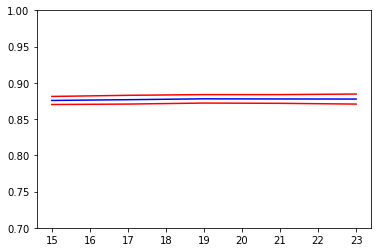

In [22]:
# Visualizamos los resultados

plt.plot(df_scores['n_neighbours'], df_scores['limite_inferior'], color='r')
plt.plot(df_scores['n_neighbours'], df_scores['score_medio'], color='b')
plt.plot(df_scores['n_neighbours'], df_scores['limite_superior'], color='r')
plt.ylim(0.7, 1);

In [23]:
# Identificamos el score máximo
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
2,0.877939,0.005826,19,0.872113,0.883765


In [24]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max(),'n_neighbours'].values[0]
best_k

19

In [26]:
# Elegimos el modelo óptimo que nos había indicado cross validation
model = KNeighborsClassifier(n_neighbors=best_k)

# Lo ajustamos sobre datos de entrenamiento
model.fit(X_train, y_train_us)

KNeighborsClassifier(n_neighbors=19)

In [27]:
from sklearn.metrics import roc_auc_score

# Evaluamos qué accuracy obtenemos en train
roc_auc_score(y_train_us, model.predict(X_train))

0.835031241510459

In [28]:
# Lo utilizamos para predecir en test
y_pred = model.predict(X_test)

# Computamos el accuracy score en test
roc_auc_score(y_test, y_pred)

0.8175488331095452

## **Naive Bayes**

In [39]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_numerical_std = pd.DataFrame(sc_X.fit_transform(X_train_numerical))
X_train_numerical_std.index = X_train_numerical.index

X_test_numerical_std = pd.DataFrame(sc_X.transform(X_test_numerical))
X_test_numerical_std.index = X_test_numerical.index

In [40]:
X_train_nai = pd.concat([X_train_numerical_std, X_train_categorical_OH], axis = 1)
X_test_nai = pd.concat([X_test_numerical_std, X_test_categorical_OH], axis = 1)

In [41]:
from sklearn.naive_bayes import GaussianNB
gaussiannb = GaussianNB()
gaussiannb.fit(X_train_nai, y_train)
gaussiannbpred = gaussiannb.predict(X_test_nai)
probs = gaussiannb.predict(X_test_nai)

print(confusion_matrix(y_test, gaussiannbpred ))
print(round(accuracy_score(y_test, gaussiannbpred),2)*100)
GAUSIAN = (cross_val_score(gaussiannb, X_train_nai, y_train, cv=k_fold, n_jobs=1, scoring = 'roc_auc').mean())

[[6127 1152]
 [ 338  621]]
82.0


## **Decision TreeClassifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini') #criterion = entopy, gini
dtree.fit(X_train, y_train)
dtreepred = dtree.predict(X_test)

print(confusion_matrix(y_test, dtreepred))
print(round(accuracy_score(y_test, dtreepred),2)*100)
DTREECV = (cross_val_score(dtree, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'roc_auc').mean())